In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
current_dir = '/content/drive/MyDrive/Apziva/MonReader/'

In [3]:
data_dir =current_dir + 'data_unchanged/images'

In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

#datetime
import datetime

#tensorflow packages
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

#keras layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

#add regularization
from tensorflow.keras import regularizers



import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#working with paths
import pathlib

https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

In [5]:
print(tf.__version__)

2.9.2


In [6]:
!pip install tensorflow-addons[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [7]:
train_folder = data_dir + '/training/'

In [8]:
print(train_folder)

/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training/


In [9]:
train_data_dir = pathlib.Path(train_folder)

In [10]:
train_data_dir

PosixPath('/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training')

In [11]:
train_image_count = len(list(train_data_dir.glob('notflip/*')))
print(train_image_count)

1230


In [12]:
batch_size = 32
img_height = 180
img_width = 180

# Create Validation Subset from the Training Samples

In [13]:
train_data_dir

PosixPath('/content/drive/MyDrive/Apziva/MonReader/data_unchanged/images/training')

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['flip', 'notflip']


It automatically finds the class names

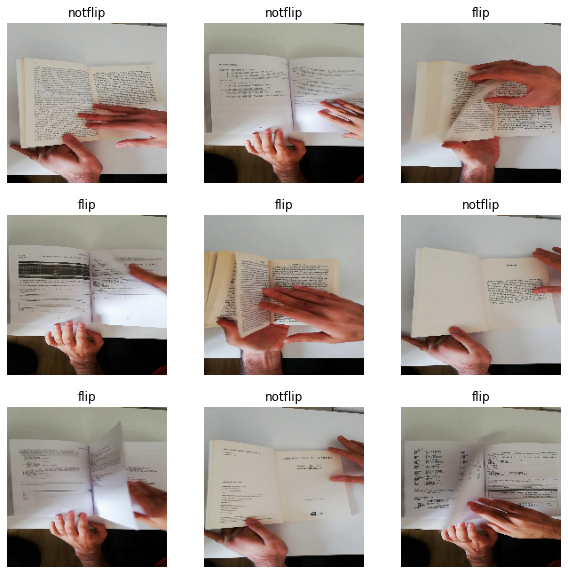

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Normalization Layer/Normalize the image pixels

In [18]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.


Dataset.prefetch overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training

In [21]:
%load_ext tensorboard

# Basic CNN architecture

In [22]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #normalization layer is here
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


# Build f-1 score metric


In [23]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [24]:
import tensorflow_addons as tfa
f1 = tfa.metrics.F1Score(num_classes=num_classes, average=None)

In [25]:
f1_metric

<function __main__.f1_metric(y_true, y_pred)>

In [26]:
f1

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', f1_metric])

In [28]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
60/60 [==============================] - 142s 2s/step - loss: 0.7031 - accuracy: 0.5758 - f1_metric: 0.1219 - val_loss: 0.6332 - val_accuracy: 0.7029 - val_f1_metric: 0.6614
Epoch 2/30
60/60 [==============================] - 2s 27ms/step - loss: 0.4719 - accuracy: 0.7607 - f1_metric: 0.6114 - val_loss: 0.4485 - val_accuracy: 0.8033 - val_f1_metric: 0.6269
Epoch 3/30
60/60 [==============================] - 2s 27ms/step - loss: 0.2746 - accuracy: 0.8887 - f1_metric: 0.6752 - val_loss: 0.2401 - val_accuracy: 0.9038 - val_f1_metric: 0.7475
Epoch 4/30
60/60 [==============================] - 2s 27ms/step - loss: 0.2270 - accuracy: 0.9133 - f1_metric: 0.6819 - val_loss: 0.2453 - val_accuracy: 0.9059 - val_f1_metric: 0.7159
Epoch 5/30
60/60 [==============================] - 2s 27ms/step - loss: 0.1698 - accuracy: 0.9389 - f1_metric: 0.6766 - val_loss: 0.1170 - val_accuracy: 0.9644 - val_f1_metric: 0.6890
Epoch 6/30
60/60 [==============================] - 2s 27ms/step - loss: 0.

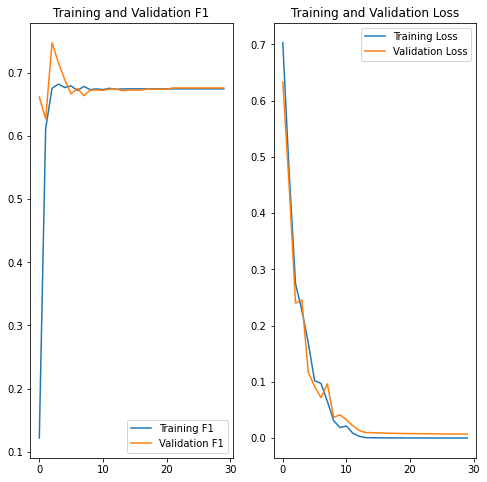

In [29]:
acc = history.history['f1_metric']
val_acc = history.history['val_f1_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training F1')
plt.plot(epochs_range, val_acc, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Training and Validation F1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
test_folder = data_dir + '/testing/'

In [31]:
test_dir = pathlib.Path(test_folder)

In [32]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 597 files belonging to 2 classes.


In [33]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
19/19 [==============================] - 52s 1s/step - loss: 0.0287 - accuracy: 0.9916 - f1_metric: 0.6892


{'loss': 0.02866823598742485,
 'accuracy': 0.9916247725486755,
 'f1_metric': 0.6891996264457703}

In [34]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 2s 75ms/step - loss: 0.0287 - accuracy: 0.9916 - f1_metric: 0.6856
test loss, test acc: [0.028668230399489403, 0.9916247725486755, 0.6856383085250854]


# Model 2: CNN with Regularization and Dropout only on the dense layers

In [35]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #normalization layer is here
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes),
])

In [36]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', f1_metric])

In [37]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
60/60 [==============================] - 2s 30ms/step - loss: 0.6714 - accuracy: 0.6019 - f1_metric: 0.1239 - val_loss: 0.6693 - val_accuracy: 0.6590 - val_f1_metric: 0.3323
Epoch 2/30
60/60 [==============================] - 2s 27ms/step - loss: 0.4885 - accuracy: 0.7685 - f1_metric: 0.5458 - val_loss: 0.3188 - val_accuracy: 0.8682 - val_f1_metric: 0.7004
Epoch 3/30
60/60 [==============================] - 2s 27ms/step - loss: 0.3410 - accuracy: 0.8605 - f1_metric: 0.5852 - val_loss: 0.2159 - val_accuracy: 0.9331 - val_f1_metric: 0.7065
Epoch 4/30
60/60 [==============================] - 2s 27ms/step - loss: 0.2456 - accuracy: 0.9154 - f1_metric: 0.6019 - val_loss: 0.1587 - val_accuracy: 0.9540 - val_f1_metric: 0.6798
Epoch 5/30
60/60 [==============================] - 2s 27ms/step - loss: 0.1735 - accuracy: 0.9467 - f1_metric: 0.6540 - val_loss: 0.1281 - val_accuracy: 0.9686 - val_f1_metric: 0.6312
Epoch 6/30
60/60 [==============================] - 2s 27ms/step - loss: 0.

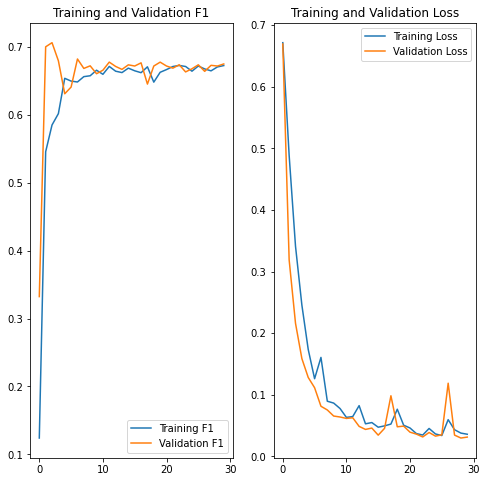

In [38]:
acc = history2.history['f1_metric']
val_acc = history2.history['val_f1_metric']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training F1')
plt.plot(epochs_range, val_acc, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Training and Validation F1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model2.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 3s 77ms/step - loss: 0.0668 - accuracy: 0.9899 - f1_metric: 0.6724
test loss, test acc: [0.06682591885328293, 0.9899497628211975, 0.672437846660614]


# Model 3 :  MobileNet V2 Model without finetuning

https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

In [40]:
IMG_SIZE = (180, 180)
IMG_SHAPE =  IMG_SIZE + (3,)

In [41]:
IMG_SHAPE

(180, 180, 3)

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [43]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


Freeze the convolutional base

It is important to freeze the convolutional base before we compile and train the model. 
Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [44]:
base_model.trainable = False

In [45]:
#base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [47]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Preprocess Input

In [48]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [49]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_mobilenetv2 = tf.keras.Model(inputs, outputs)

In [50]:
initial_epochs=10

In [51]:
base_learning_rate = 0.0001
model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy',f1_metric])

In [52]:
history_mobilenetv2 = model_mobilenetv2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
60/60 [==============================] - 6s 59ms/step - loss: 0.7134 - accuracy: 0.5465 - f1_metric: 0.4144 - val_loss: 0.6357 - val_accuracy: 0.6046 - val_f1_metric: 0.5023
Epoch 2/10
60/60 [==============================] - 2s 36ms/step - loss: 0.6556 - accuracy: 0.5904 - f1_metric: 0.5100 - val_loss: 0.5955 - val_accuracy: 0.6318 - val_f1_metric: 0.5378
Epoch 3/10
60/60 [==============================] - 2s 36ms/step - loss: 0.6108 - accuracy: 0.6270 - f1_metric: 0.5489 - val_loss: 0.5652 - val_accuracy: 0.6674 - val_f1_metric: 0.6073
Epoch 4/10
60/60 [==============================] - 2s 37ms/step - loss: 0.5874 - accuracy: 0.6520 - f1_metric: 0.5881 - val_loss: 0.5398 - val_accuracy: 0.6967 - val_f1_metric: 0.6542
Epoch 5/10
60/60 [==============================] - 2s 37ms/step - loss: 0.5546 - accuracy: 0.6813 - f1_metric: 0.6253 - val_loss: 0.5167 - val_accuracy: 0.7218 - val_f1_metric: 0.6788
Epoch 6/10
60/60 [==============================] - 2s 37ms/step - loss: 0.

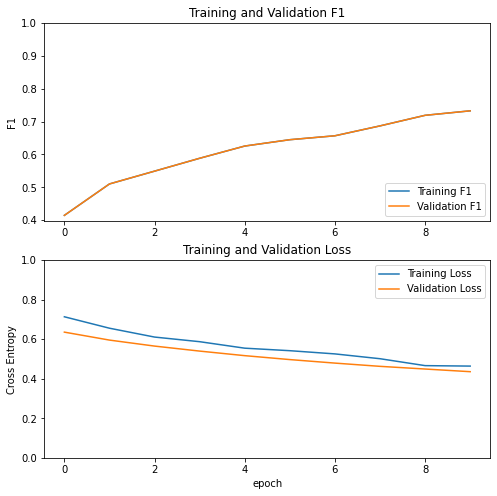

In [53]:
acc = history_mobilenetv2.history['f1_metric']
val_acc = history_mobilenetv2.history['f1_metric']

loss = history_mobilenetv2.history['loss']
val_loss = history_mobilenetv2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training F1')
plt.plot(val_acc, label='Validation F1')
plt.legend(loc='lower right')
plt.ylabel('F1')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_mobilenetv2.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 3s 102ms/step - loss: 0.4543 - accuracy: 0.7906 - f1_metric: 0.7729
test loss, test acc: [0.45434579253196716, 0.7906197905540466, 0.7728598117828369]


# Model 4 - Fine Tuning MobileNetV2

Fine tuning model 3 for the task

In [55]:
base_model.trainable = True

In [56]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [57]:
len(model_mobilenetv2.trainable_variables)

56

In [58]:
model_mobilenetv2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', f1_metric])

In [59]:
model_mobilenetv2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [60]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs



In [63]:
history_fine = model_mobilenetv2.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_mobilenetv2.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
60/60 [==============================] - 8s 65ms/step - loss: 0.3250 - accuracy: 0.8579 - f1_metric: 0.8440 - val_loss: 0.2353 - val_accuracy: 0.9163 - val_f1_metric: 0.9126
Epoch 11/20
60/60 [==============================] - 3s 49ms/step - loss: 0.1752 - accuracy: 0.9336 - f1_metric: 0.9296 - val_loss: 0.1451 - val_accuracy: 0.9372 - val_f1_metric: 0.9326
Epoch 12/20
60/60 [==============================] - 3s 49ms/step - loss: 0.1069 - accuracy: 0.9624 - f1_metric: 0.9604 - val_loss: 0.1173 - val_accuracy: 0.9603 - val_f1_metric: 0.9593
Epoch 13/20
60/60 [==============================] - 3s 49ms/step - loss: 0.0739 - accuracy: 0.9749 - f1_metric: 0.9740 - val_loss: 0.0677 - val_accuracy: 0.9749 - val_f1_metric: 0.9727
Epoch 14/20
60/60 [==============================] - 3s 49ms/step - loss: 0.0461 - accuracy: 0.9854 - f1_metric: 0.9845 - val_loss: 0.0529 - val_accuracy: 0.9749 - val_f1_metric: 0.9737
Epoch 15/20
60/60 [==============================] - 3s 49ms/step - lo

In [62]:
history_fine

In [65]:
acc += history_fine.history['f1_metric']
val_acc += history_fine.history['f1_metric']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

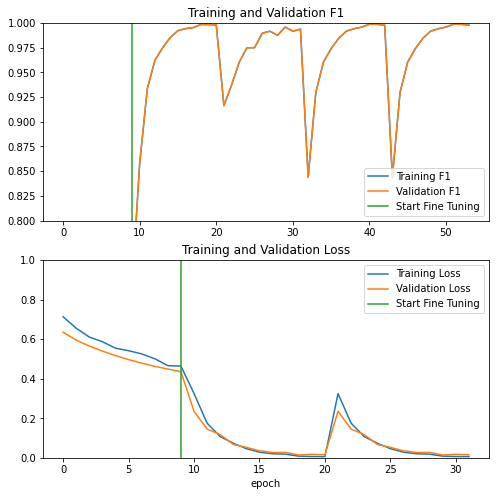

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training F1')
plt.plot(val_acc, label='Validation F1')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation F1')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [67]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_mobilenetv2.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 3s 87ms/step - loss: 0.0272 - accuracy: 0.9933 - f1_metric: 0.9937
test loss, test acc: [0.027195552363991737, 0.9932998418807983, 0.9937386512756348]


# Prediction on a Batch of Images

It seems that 1 is notflip and 0 is flip

Predictions:
 [0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1]
Labels:
 [0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1]


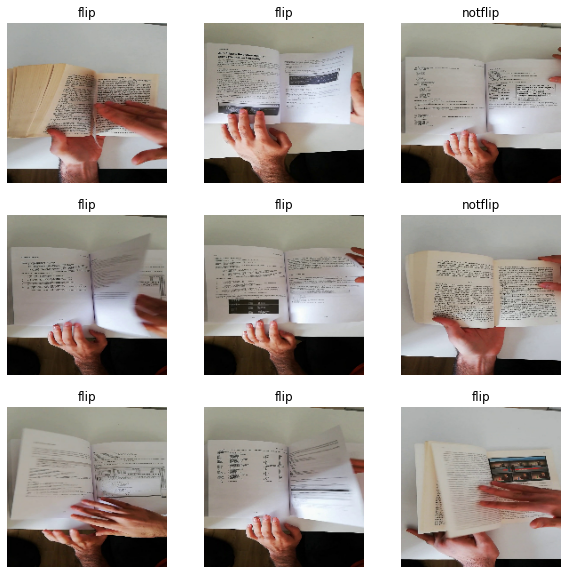

In [68]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_mobilenetv2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Look at the case where a flip is misclassified (27th data point)

-1
-2
-3
-4
-5
-6
-7
-8
-9


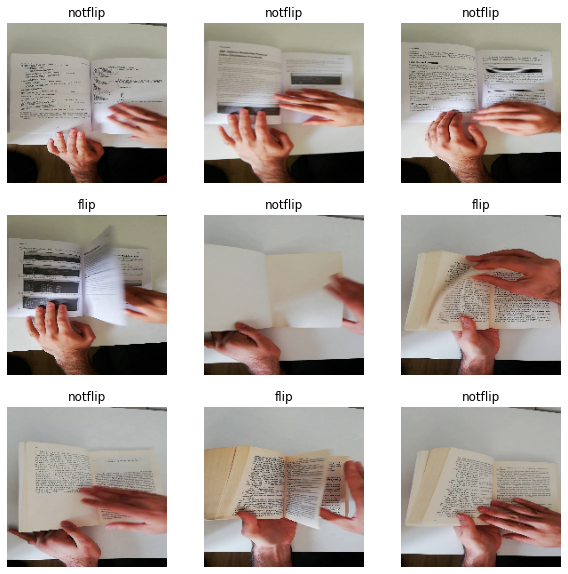

In [76]:
plt.figure(figsize=(10, 10))
for i in range(1,10):
  print(-1*i)
  ax = plt.subplot(3, 3, i)
  plt.imshow(image_batch[-1*i].astype("uint8"))
  plt.title(class_names[predictions[-1*i]])
  plt.axis("off")

In [71]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1]
Labels:
 [0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1]


# Model Inference: Predict if a given sequence of images contains an action of flipping.

## Save Model

In [77]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1




Saved model:
total 196
drwxr-xr-x 2 root root   4096 Dec  8 13:18 assets
-rw-r--r-- 1 root root  19846 Dec  8 13:18 keras_metadata.pb
-rw-r--r-- 1 root root 170204 Dec  8 13:18 saved_model.pb
drwxr-xr-x 2 root root   4096 Dec  8 13:18 variables


In [79]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['rescaling_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_rescaling_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          

## Serve model with TensorFlow Serving

In [80]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [81]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18626      0 --:--:-- --:--:-- --:--:-- 18626
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/co

In [83]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 414 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.11.0 [414 MB]
Fetched 414 MB in 14s (30.1 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.11.0_all.deb ...
Unpacking tensorflow-model-server (2.11.0) ...
Setting up tensorflow-model-server (2.11.0) ...


##Run the API

In [84]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [146]:
!nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=monreader_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [147]:
!tail server.log

nohup: ignoring input
tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


## Show random image from test data

In [89]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [120]:
batch_test = test_ds.take(1)

In [127]:
images_list = []
labels_list = []

In [128]:
for image, label in tfds.as_numpy(batch_test):
  print(type(image), type(label), label)
  images_list = image
  labels_list = label

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0]


In [130]:
type(images_list)

numpy.ndarray

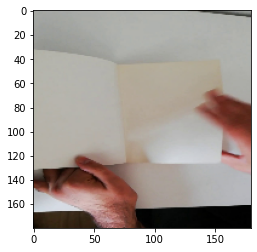

In [136]:
plt.imshow(images_list[20].astype("uint8"))

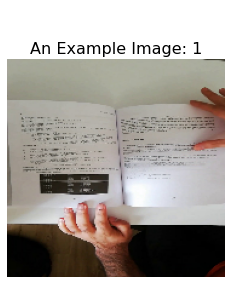

In [138]:
def show(idx, title):
  plt.figure()
  plt.imshow(images_list[idx].astype("uint8"))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(images_list)-1)
show(rando, 'An Example Image: {}'.format(labels_list[rando]))


In [141]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": images_list[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 2.0, 2.0, 2.0], [2.0, 2.0, 2.0], [2.0, 2.0, 0.0]]]]}


In [143]:
# docs_infra: no_execute
!pip install -q requests

## Test the API

In [144]:
import requests

In [145]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/monreader_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[labels_list[0]], labels_list[0]))

ConnectionError: ignored

Due to Google Colab Local API error, we will just use local model prediction

# Model Inference (Local): Predict if a given sequence of images contain an action of flipping.

Predictions:
 [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
Labels:
 [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]


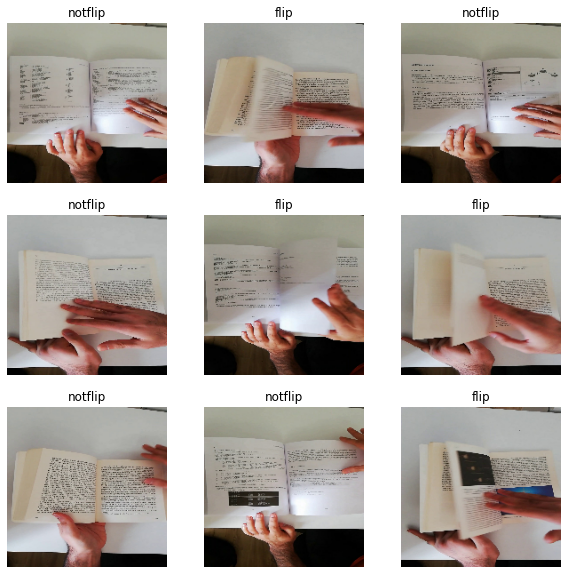

In [148]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_mobilenetv2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [149]:
0 in predictions

True

In [150]:
def sequence_predict(image_batch,label_batch):
  #get predictions
  predictions = model_mobilenetv2.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', predictions.numpy())
  print('Labels:\n', label_batch)

  return 0 in predictions



In [151]:
sequence_predict(image_batch,label_batch)

Predictions:
 [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
Labels:
 [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]


True